# VQA v2.0 Interactive Notebook

## Import Libraries

In [1]:
# Import libraries
import importlib
import os
from collections import Counter
from typing import Iterable

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from transformers import BertModel, BertTokenizerFast


In [2]:
# Check GPU
if not torch.cuda.is_available():
    raise RuntimeError("GPU with CUDA support is required")
device = torch.device("cuda")


In [3]:
# Import utils
if not os.path.exists("./utils"):
    !git clone https://github.com/ZhangShaozuo/Artificial_Intelligence_VQA.git
    !ln -s ./DL-BigProject-VQA/utils ./utils

if os.path.exists("./DL-BigProject-VQA/utils"):
    !cd ./DL-BigProject-VQA/utils && git pull

import utils.data as data_util
import utils.helper as helper
import utils.train as train_util
from utils.vocab import Vocab

importlib.reload(data_util)
importlib.reload(helper)
importlib.reload(train_util)
pass


## Load Dataset

In [4]:
# Load dataset (single word answer only)
image_transform = transforms.Compose(
    [
        transforms.Resize(int(224 / 0.875)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

answer_vocab = Vocab({})


def answer_tansform(answer: str):
    return answer_vocab[answer]


def answer_tansform_factory(corpus: Iterable[str]):
    global answer_vocab
    answer_vocab = Vocab(Counter(corpus), specials=["<unk>"], min_freq=10)
    return answer_tansform


train_dataset = data_util.VQA2Dataset(
    "./VQA2/",
    group="train",
    image_transform=image_transform,
    answer_transform_factory=answer_tansform_factory,
    download=True,
)

valid_dataset = data_util.VQA2Dataset(
    "./VQA2/",
    group="val",
    image_transform=image_transform,
    answer_transform=answer_tansform,
)

test_dataset = data_util.VQA2Dataset(
    "./VQA2/",
    group="test",
    image_transform=image_transform,
    answer_transform=answer_tansform,
)

print("train_dataset:", len(train_dataset))
print("valid_dataset:", len(valid_dataset))
print("test_dataset:", len(test_dataset))
print("answer_vocab size:  ", len(answer_vocab))


train_dataset: 411198
valid_dataset: 138617
test_dataset: 59678
answer_vocab size:   1823


## Create Dataloader

In [5]:
# Create dataloader
batch_size = 32
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def generate_batch(data_batch):
    images, questions, answers = zip(*data_batch)
    images = torch.stack(images, 0).to(device)
    question_inputs = tokenizer(list(questions), padding=True)
    question_inputs = {k: torch.tensor(v, dtype=torch.long).to(device) for k, v in question_inputs.items()}
    answers = torch.tensor(answers, dtype=torch.long).to(device)
    return images, question_inputs, answers


train_loader = DataLoader(
    train_dataset, batch_size=batch_size, collate_fn=generate_batch, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, collate_fn=generate_batch
)

# use a subset of the validation dataset
mini_valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    collate_fn=generate_batch,
    sampler=SubsetRandomSampler(list(range(512))),
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=generate_batch, shuffle=True)


Q: [CLS] is there a monkey in the picture? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
A: no


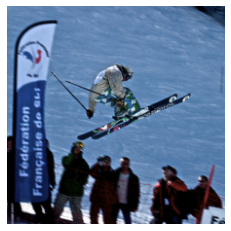

Q: [CLS] how many other vehicles are on the runway? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
A: 4


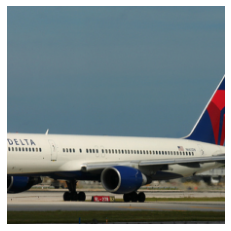

Q: [CLS] is the person a male or female? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
A: female


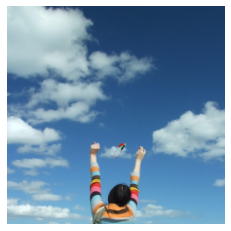

Q: [CLS] what holiday is the room decorated for? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
A: christmas


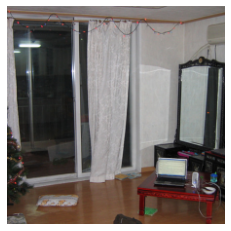

In [7]:
# Visualize some samples
def visualize_samples(images, questions, answers, max_num=-1):
    if max_num < 0:
        max_num = len(images)

    for _, v, q, a in zip(range(max_num), images, questions["input_ids"], answers):
        print("Q:", tokenizer.decode(q))
        print("A:", answer_vocab.itos[a])
        helper.imshow(v.cpu())
        plt.show()


images, questions, answers = next(iter(train_loader))
visualize_samples(images, questions, answers, max_num=4)


## Create Model

In [8]:
class VNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        model = torchvision.models.resnet152(pretrained=pretrained)
        model.fc = nn.Linear(2048, 768)
        self.backbone = model

    def forward(self, images):
        return self.backbone(images)


In [9]:
class VQANet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.v_net = VNet()
        self.q_net = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Sequential(
            nn.Linear(768, 1024),
            nn.ReLU(True),
            nn.Linear(1024, num_classes)
        )

    def forward(self, v, q):
        v_feat = self.v_net(v)
        q_feat = self.q_net(**q)[1]
        out = self.classifier(v_feat * q_feat)
        return out


In [10]:
model = VQANet(len(answer_vocab)).to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Train Model

Epoch: 1/2 @ 2021-07-28 11:09:36.447015
12850/12850 [==============================] - 10925s 850ms/step - loss: 1.225 - accuracy: 0.585 - topk_accuracy: 0.905 - val_loss: 1.559 - val_accuracy: 0.504 - val_topk_accuracy: 0.887 - saved to checkpoints\2021-07-28_11-09\ckpt_00.pth
Epoch: 2/2 @ 2021-07-28 14:11:41.123284
12850/12850 [==============================] - 10481s 816ms/step - loss: 1.161 - accuracy: 0.609 - topk_accuracy: 0.915 - val_loss: 1.613 - val_accuracy: 0.516 - val_topk_accuracy: 0.895 - saved to checkpoints\2021-07-28_11-09\ckpt_01.pth


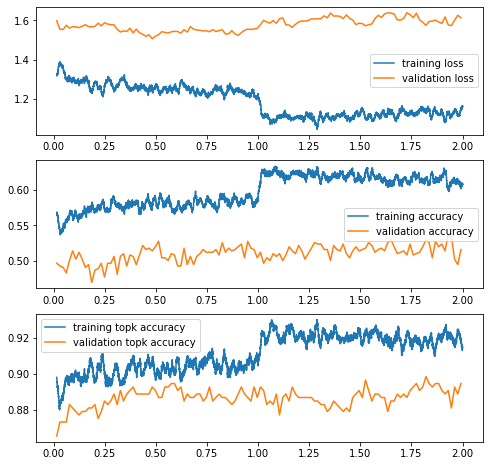

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

history = train_util.train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    mini_valid_loader,
    epochs=2,
    valid_every=200,
)
train_util.plot_history(history)


In [12]:
# train_util.load_model(model, "./checkpoints/2021-07-28_11-09/ckpt_01.pth")
# pass

## Test Model

In [13]:
# Accuracy on the mini validation set
mini_valid_loss, mini_valid_accu, mini_valid_topk_accu = train_util.validate_model(
    model, mini_valid_loader, nn.CrossEntropyLoss()
)
print("loss:", mini_valid_loss)
print("accu:", mini_valid_accu)
print("topk_accu:", mini_valid_topk_accu)


loss: 1.608911618590355
accu: 0.513671875
topk_accu: 0.890625


In [27]:
# Accuracy on the full validation set
valid_loss, valid_accu, valid_topk_accu = train_util.validate_model(
    model, valid_loader, nn.CrossEntropyLoss(), show_progress=True
)
print("loss:", valid_loss)
print("accu:", valid_accu)
print("topk_accu:", valid_topk_accu)


4332/4332 [==============================] - 1474s 340ms/step
loss: 1.7131185271430653
accu: 0.5022832751274109
topk_accu: 0.8580909967422485


In [28]:
# Accuracy on the test set
test_loss, test_accu, test_topk_accu = train_util.validate_model(
    model, test_loader, nn.CrossEntropyLoss(), show_progress=True
)
print("loss:", test_loss)
print("accu:", test_accu)
print("topk_accu:", test_topk_accu)


1865/1865 [==============================] - 636s 341ms/step
loss: 1.7082117946793502
accu: 0.5009048581123352
topk_accu: 0.8608365058898926


Q: [CLS] what is the shiniest object in this photo? [SEP] [PAD]
A: blender
Model: <unk>


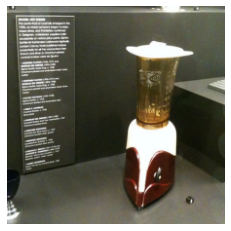

Q: [CLS] does the bear appear well - fed? [SEP] [PAD] [PAD] [PAD]
A: no
Model: yes


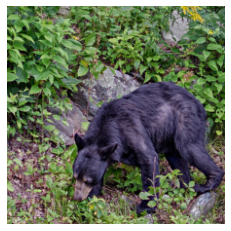

Q: [CLS] is the player looking at the ball? [SEP] [PAD] [PAD] [PAD]
A: yes
Model: yes


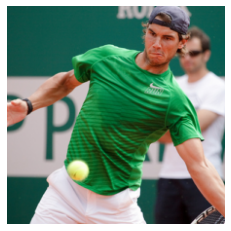

Q: [CLS] how many cups can you see in the picture? [SEP] [PAD]
A: 0
Model: 0


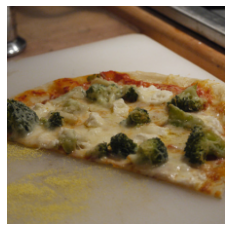

In [15]:
# Plot some samples
images, questions, answers = next(iter(test_loader))
model.eval()
with torch.no_grad():
    outputs = model(images, questions)
predictions = torch.argmax(outputs, dim=1).cpu()

for _, v, q, a, pred in zip(range(4), images, questions["input_ids"], answers, predictions):
    print("Q:", tokenizer.decode(q))
    print("A:", answer_vocab.itos[a])
    print("Model:", answer_vocab.itos[pred])
    helper.imshow(v.cpu())
    plt.show()
